In [1]:
cd ../../src

/Users/in-divye.singh/Documents/Projects/MIC_predictor/src


In [2]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain, combinations
from collections import Counter

from utils import *

from sklearn.svm import SVR
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from Bio.SeqUtils.ProtParam import ProteinAnalysis

In [3]:
import seaborn as sns

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

In [5]:
avp_ic50 = pd.read_csv("../data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("../data/raw/HA_AVP.csv")

In [6]:
df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [7]:
df = df.sample(frac=1, random_state=9).reset_index(drop=True)
df

,Sequence,MIC
0,WEDWVRWI,0.057
1,SLERLDVGTNLGNAIAKLEDAKELLESSDQILRSM,12.300
2,TTWEAWDRAIAEYAARIEALIRALQELQEKNEAALREL,0.014
3,IINFYDPLVFPSDEFDASISQVNEKINQSLAFIRK,91.000
4,TDVILMCASIDSPDSLENI,6.290
...,...,...
707,RSQKEGLHYTCSSHFPYSQYQFWK,136.000
708,FLHFLHHLF,0.811
709,EWDREINNYTSLIHSLIEESQNQQEKNEQELLELDK,0.012
710,ALDKAEESNSKLDKVNVKLT,6.000


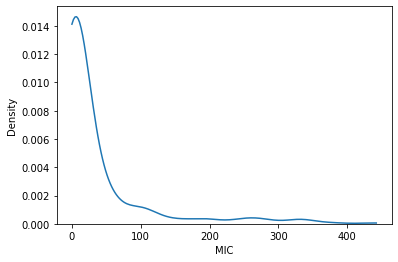

In [8]:
sns.kdeplot(x=df['MIC'], cut=0)

In [9]:
def get_physicochemical_properties(df):
    params = ['aromaticity', 'helix', 'turn', 'sheet', 'gravy', 'net_charge_at_pH7point4']

    prop = []
    for seq in df.Sequence:
        X = ProteinAnalysis(seq)
        aromaticity = X.aromaticity()
        sec_struc = X.secondary_structure_fraction()
        helix = sec_struc[0]
        turn = sec_struc[1]
        sheet = sec_struc[2]
        gravy = X.gravy() # hydrophobicity related
        net_charge_at_pH7point4 = X.charge_at_pH(7.4)

        prop.append([aromaticity, helix, turn, sheet, gravy, net_charge_at_pH7point4])
    return pd.DataFrame(prop, columns=params)

In [10]:
aa_freq = reduce_by_kmer_frequency(df)

In [11]:
uniprot_embedding = biovec.models.load_protvec("../data/embeddings/uniprot__kmer_3_contextWindow_10_vector_100_reduction_None")

avg_protvec = convert_sequences_to_avg_vectors(df['Sequence'], uniprot_embedding, kmer=3)
avg_protvec = avg_protvec.reset_index(drop=True)

/Users/in-divye.singh/anaconda3/envs/life-science/lib/python3.6/site-packages/smart_open/smart_open_lib.py:254: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
Creating vectors: 100%|██████████| 712/712 [00:01<00:00, 508.40sequence/s]


In [12]:
physicochemical_prop = get_physicochemical_properties(df)

In [13]:
X = pd.concat([aa_freq, avg_protvec, physicochemical_prop[['helix','turn','sheet']]], axis=1)

In [14]:
y = df['MIC']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
from geneal.genetic_algorithms import ContinuousGenAlgSolver

In [17]:
from sklearn.model_selection import cross_val_score, cross_validate

In [18]:
svr = SVR()
cv_score = cross_val_score(svr, X_train, y_train, cv=5, scoring=mape_scorer)
cv_score.mean()

-437113.7900073404

In [19]:
cv_score

array([  -13506.59416206,   -13582.64853974,  -126232.09412479,
          -6965.90307535, -2025281.71013476])

In [20]:
from statsmodels.distributions.empirical_distribution import ECDF

In [21]:
ecdf = ECDF(df['MIC'])

In [55]:
sample_weights = [-np.log(mic*1e-6)+np.exp(mic*1e-2)/4 for mic in y_train]#[ecdf(mic)+(mic/2) for mic in y_train]

In [56]:
1/(X_train.shape[1]*X_train.values.var())

1.6340301855208665

In [57]:
svr = SVR(C=1, gamma='scale') # gamma=1.5831 for full data

In [58]:
_ = svr.fit(X_train, y_train)#, sample_weight=sample_weights)

In [59]:
y_pred = svr.predict(X_test)

In [60]:
mean_absolute_percentage_error(y_test, y_pred)

243778.2299420093

In [61]:
from scipy.stats import pearsonr

In [62]:
pearsonr(y_test, y_pred)

(0.34396290322026957, 2.597340231614349e-05)

In [63]:
ape = 100*np.abs(y_test-y_pred)/y_test

In [64]:
list(zip(y_test, y_pred, ape))

[(0.006999999999999999, 5.983095454299256, 85372.79220427509),
 (8.71, 11.091560752950192, 27.34283298450277),
 (0.35, 8.527030405865087, 2336.2944016757397),
 (12.5, 4.253148513471693, 65.97481189222646),
 (0.125, 7.952905461097618, 6262.324368878095),
 (2.5, 8.411730169133016, 236.46920676532062),
 (33.0, 11.012625158967136, 66.6284086091905),
 (12.0, 8.074890801165228, 32.7092433236231),
 (10.8, 6.969646219940291, 35.46623870425657),
 (5.0, 8.590476019832998, 71.80952039665996),
 (2.85, 10.513114414062176, 268.8812075109536),
 (0.46, 8.239585758516075, 1691.2142953295815),
 (10.0, 7.083418935572015, 29.165810644279844),
 (20.0, 5.482498947575924, 72.58750526212039),
 (8.0, 5.4641142488910095, 31.698571888862382),
 (2.9999999999999997e-05, 6.5332500947655925, 21777400.315885313),
 (0.2, 17.71213658978599, 8756.068294892995),
 (100.0, 8.1840921748131, 91.8159078251869),
 (50.0, 5.893696894455158, 88.21260621108968),
 (0.14, 5.459704472502316, 3799.7889089302253),
 (0.55, 5.51311337534

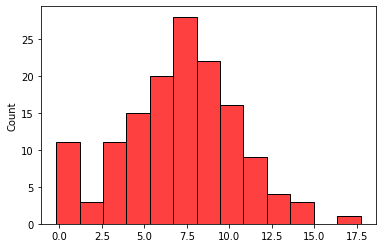

In [65]:
sns.histplot(x=y_pred, color='red')

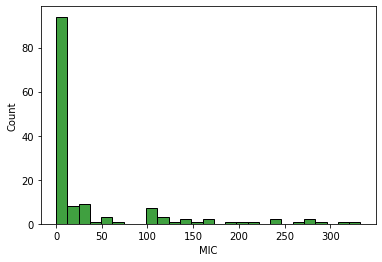

In [66]:
sns.histplot(x=y_test, color='green')

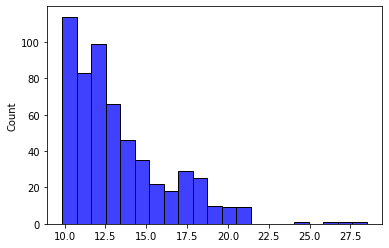

In [68]:
sns.histplot(x=sample_weights, color='blue')

In [53]:
sample_weights = [-np.log(mic*1e-6)+np.exp(mic*1e-2)/4 for mic in y_train]

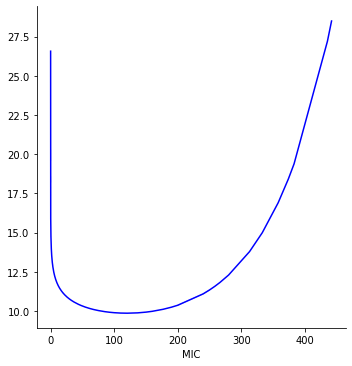

In [67]:
sns.relplot(x=y_train, y=sample_weights, kind='line', color='blue')

In [77]:
mic = 100
-np.log(mic*1e-6)+np.exp(mic*1e-2)/4

9.889910829090946